In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

def facecolors_with_lighting(
    X, Y, Z, *,
    scalar=None,
    cmap="viridis",
    norm=None,
    light_dirs=((1, 1, 2), (-1, -1, 1)),
    light_weights=(1.0, 0.35),
    ambient=0.55,
    wrap=True,
    gamma=0.7,
    strength=0.6,
    quadric_ev=None
):
    X = np.asarray(X, float); Y = np.asarray(Y, float); Z = np.asarray(Z, float)
    if scalar is None:
        scalar = Z
    scalar = np.asarray(scalar, float)

    if norm is None:
        norm = colors.Normalize(vmin=np.nanmin(scalar), vmax=np.nanmax(scalar))
    base = cm.get_cmap(cmap)(norm(scalar))


    if quadric_ev is not None:
        ev = np.asarray(quadric_ev, float)
        Nx, Ny, Nz = ev[0]*X, ev[1]*Y, ev[2]*Z
    else:
        Xu, Xv = np.gradient(X); Yu, Yv = np.gradient(Y); Zu, Zv = np.gradient(Z)
        Nx = Yu * Zv - Zu * Yv
        Ny = Zu * Xv - Xu * Zv
        Nz = Xu * Yv - Yu * Xv

    N = np.sqrt(Nx*Nx + Ny*Ny + Nz*Nz) + 1e-12
    Nx, Ny, Nz = Nx/N, Ny/N, Nz/N


    if np.nanmean(Nx*X + Ny*Y + Nz*Z) < 0:
        Nx, Ny, Nz = -Nx, -Ny, -Nz

    diffuse = 0.0
    wsum = 0.0
    for (lx, ly, lz), w in zip(light_dirs, light_weights):
        L = np.array([lx, ly, lz], float)
        L /= (np.linalg.norm(L) + 1e-12)
        ndotl = Nx*L[0] + Ny*L[1] + Nz*L[2]

        d = 0.5*(ndotl + 1.0) if wrap else np.clip(ndotl, 0, 1)
        diffuse += w * np.clip(d, 0, 1)
        wsum += w

    diffuse = (diffuse / max(wsum, 1e-12)) ** gamma
    intensity = ambient + (1 - ambient) * diffuse

    rgb = base[..., :3]
    rgb_shaded = rgb * intensity[..., None]
    base[..., :3] = (1 - strength) * rgb + strength * rgb_shaded

    return base, norm


[[  2   5   2]
 [  5   6 -10]
 [  2 -10   6]]
eig: [0. 0. 1.] axes: [inf inf  1.]


/tmp/ipython-input-2320864103.py:373: RuntimeWarning: divide by zero encountered in divide
  print("eig:", eig_pp, "axes:", np.sqrt(1/(eig_pp)))
/tmp/ipython-input-2802568053.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(cmap)(norm(scalar))


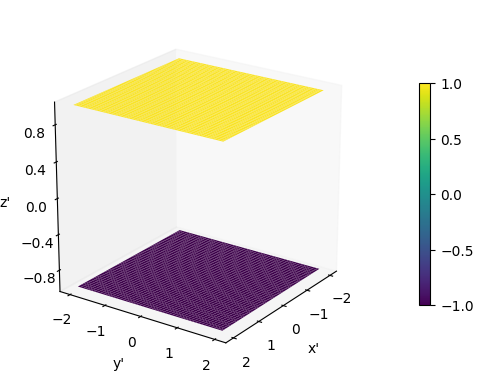

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
from matplotlib import cm, colors


matrix_dimension=3
a, b, c = 6.0, 2.0, 0.5

def gen_hermitian_matrix(size = 3):
    A = np.random.randint(low=-5,high=5,size=(3, 3))
    A = A + A.conj().T
    return A


def reset_matrix(ii, jj, xx):
    A = 1*base_matrix
    A[ii][jj], A[jj,ii] = xx ,xx
    return A

base_matrix = gen_hermitian_matrix(matrix_dimension)

print(base_matrix)

eigenvalues, eigenvectors = np.linalg.eigh(base_matrix)



def classify(ev, tol=1e-9):
    ev = np.asarray(ev, dtype=float)
    pos  = np.sum(ev >  tol)
    neg  = np.sum(ev < -tol)
    zero = np.sum(np.abs(ev) <= tol)

    if zero == 0:
        if pos == 3: return "Ellipsoid"
        if pos == 2 and neg == 1: return "Hyperboloid of One Sheet"
        if pos == 1 and neg == 2: return "Hyperboloid of Two Sheets"
        return "Other/Imaginary"

    if zero == 1:
        if pos == 2: return "Elliptic Cylinder"
        if pos == 1 and neg == 1: return "Hyperbolic Cylinder"
        if neg == 2: return "No real points (imaginary cylinder)"
        return "Degenerate/Other"

    if zero == 2:
        if pos == 1: return "Two Parallel Planes"
        if neg == 1: return "No real points (imaginary planes)"
        return "Degenerate/Other"
    return "No real points (0 = 1)"


def plot_quadric(eigenvalues, tol=1e-9, L=2.0):
    ev = np.asarray(eigenvalues, dtype=float)

    zero_idx = np.where(np.abs(ev) <= tol)[0]
    nz_idx   = np.where(np.abs(ev) >  tol)[0]

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    title = classify(ev)
    ax.set_box_aspect([1, 1, 1], zoom = 0.92)

    ax.set_proj_type("persp")
    ax.view_init(elev=22, azim=35)
    ax.grid(False)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    ax.tick_params(axis="x", pad=2)
    ax.tick_params(axis="y", pad=2)
    ax.tick_params(axis="z", pad=2)


    if len(zero_idx) == 0:
        a, b, c = np.sqrt(1 / np.abs(ev))

        u = np.linspace(0, 2*np.pi, 200)
        v = np.linspace(0, np.pi, 200)

        if np.all(ev > 0):  # Ellipsoid
            eps = 1e-3
            v = np.linspace(eps, np.pi-eps, 200)
            ax.set_xlim(-a, a)
            ax.set_ylim(-b, b)
            ax.set_zlim(-c, c)
            ax.zaxis.set_major_locator(MultipleLocator(0.5))
            ax.xaxis.set_major_locator(MultipleLocator(0.5))
            ax.yaxis.set_major_locator(MultipleLocator(0.5))


            x = a * np.outer(np.cos(u), np.sin(v))
            y = b * np.outer(np.sin(u), np.sin(v))
            z = c * np.outer(np.ones_like(u), np.cos(v))

            fc, norm = facecolors_with_lighting(x, y, z, cmap="viridis", ambient=0.25)
            ax.plot_surface(
            x, y, z,
            facecolors=fc,
            linewidth=0,
            antialiased=True,
            shade=False, edgecolor="none"
        )
            mappable = cm.ScalarMappable(norm=norm, cmap="viridis")
            mappable.set_array([])
            fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.08)

        elif np.sum(ev > 0) == 2:  # Hyperboloid of one sheet
            vv = np.linspace(-2, 2, 200)
            x = a * np.outer(np.cos(u), np.cosh(vv))
            y = b * np.outer(np.sin(u), np.cosh(vv))
            z = c * np.outer(np.ones_like(u), np.sinh(vv))
            fc, norm = facecolors_with_lighting(x, y, z, scalar=z, cmap="viridis", wrap=True, ambient=0.55)

            ax.plot_surface(x, y, z, facecolors=fc, shade=False, linewidth=0, edgecolor="none", antialiased=True)

            m = cm.ScalarMappable(norm=norm, cmap="viridis")
            m.set_array([])
            fig.colorbar(m, ax=ax, shrink=0.6, pad=0.08)

        elif np.sum(ev > 0) == 1:  # Hyperboloid of two sheets
            eps = 1e-3
            s = np.linspace(eps, 2, 200)
            t = np.linspace(0, 2*np.pi, 200)
            x_u = a * np.outer(np.sinh(s), np.cos(t))
            y_u = b * np.outer(np.sinh(s), np.sin(t))
            z_u = c * np.outer(np.cosh(s), np.ones_like(t))

            fc_top, _ = facecolors_with_lighting(x_u, y_u,  z_u, cmap="viridis", ambient=0.25)
            fc_bot, _ = facecolors_with_lighting(x_u, y_u, -z_u, cmap="viridis", ambient=0.25)

            scalar_top = z_u
            scalar_bot = -z_u

            vmin = min(np.nanmin(scalar_top), np.nanmin(scalar_bot))
            vmax = max(np.nanmax(scalar_top), np.nanmax(scalar_bot))
            shared_norm = colors.Normalize(vmin=vmin, vmax=vmax)

            fc_top, _ = facecolors_with_lighting(x_u, y_u,  z_u, scalar=scalar_top, cmap="viridis", ambient=0.25, norm=shared_norm)
            fc_bot, _ = facecolors_with_lighting(x_u, y_u, -z_u, scalar=scalar_bot, cmap="viridis", ambient=0.25, norm=shared_norm)

            ax.plot_surface(x_u, y_u,  z_u, facecolors=fc_top, linewidth=0, shade=False, edgecolor="none")
            ax.plot_surface(x_u, y_u, -z_u, facecolors=fc_bot, linewidth=0, shade=False, edgecolor="none")

            mappable = cm.ScalarMappable(norm=shared_norm, cmap="viridis")
            mappable.set_array([])
            fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.08)


        else:
            return

        ax.set_xlabel("x'"); ax.set_ylabel("y'"); ax.set_zlabel("z'")
        plt.savefig("plot.pdf")
        return
    if len(zero_idx) == 1:
        k = int(zero_idx[0])
        i, j = nz_idx

        u = np.linspace(0, 2*np.pi, 200)
        t = np.linspace(-L, L, 200)

        Ui = np.outer(np.cos(u), np.ones_like(t))
        Uj = np.outer(np.sin(u), np.ones_like(t))
        T  = np.outer(np.ones_like(u), t)

        if ev[i] > tol and ev[j] > tol:
            ai = np.sqrt(1.0 / ev[i])
            aj = np.sqrt(1.0 / ev[j])

            coords = [None, None, None]
            coords[i] = ai * Ui
            coords[j] = aj * Uj
            coords[k] = T
            X,Y,Z = coords[0], coords[1], coords[2]

            fc, norm = facecolors_with_lighting(X,Y,Z, cmap="viridis", ambient=0.25)

            ax.plot_surface(
                X, Y, Z,
                facecolors=fc,
                linewidth=0,
                antialiased=True,
                shade=False, edgecolor="none"
            )

            ax.zaxis.set_major_locator(MultipleLocator(0.5))
            ax.xaxis.set_major_locator(MultipleLocator(0.5))
            ax.yaxis.set_major_locator(MultipleLocator(0.5))
            mappable = cm.ScalarMappable(norm=norm, cmap="viridis")
            mappable.set_array([])
            fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.08)

            plt.savefig("plot.pdf")

        elif (ev[i] > tol and ev[j] < -tol) or (ev[i] < -tol and ev[j] > tol):
            p = i if ev[i] > 0 else j
            n = j if p == i else i

            a = np.sqrt(1.0 / ev[p])
            b = np.sqrt(1.0 / abs(ev[n]))

            s = np.linspace(-2, 2, 200)
            t = np.linspace(-L, L, 200)
            S = np.outer(np.ones_like(t), s).T
            T = np.outer(np.ones_like(s), t)

            Xp1 =  a * np.cosh(S)
            Xp2 = -a * np.cosh(S)
            Xn  =  b * np.sinh(S)


            scalar_shared = T
            shared_norm = colors.Normalize(vmin=np.nanmin(scalar_shared), vmax=np.nanmax(scalar_shared))

            def plot_branch(Xp):
                coords1 = [None, None, None]; coords1[p]=Xp1; coords1[n]=Xn; coords1[k]=T
                coords2 = [None, None, None]; coords2[p]=Xp2; coords2[n]=Xn; coords2[k]=T
                Z1 = coords1[2]   # because coords order is [x',y',z']
                Z2 = coords2[2]

                shared_norm = colors.Normalize(
                    vmin=min(np.nanmin(Z1), np.nanmin(Z2)),
                    vmax=max(np.nanmax(Z1), np.nanmax(Z2))
                )
                coords = [None, None, None]
                coords[p] = Xp     # + eigen direction
                coords[n] = Xn
                coords[k] = T

                X, Y, Z = coords

                fc, _ = facecolors_with_lighting(
                    X, Y, Z,
                    scalar=Z,
                    norm=shared_norm,
                    cmap="viridis",
                    wrap=True, ambient=0.55
                )

                ax.plot_surface(X, Y, Z, facecolors=fc, shade=False,
                                linewidth=0, edgecolor="none", antialiased=True)

            plot_branch(Xp1)
            plot_branch(Xp2)

            mappable = cm.ScalarMappable(norm=shared_norm, cmap="viridis")
            mappable.set_array([])
            fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.08)

        else:
            return

        ax.set_xlabel("x'"); ax.set_ylabel("y'"); ax.set_zlabel("z'")
        plt.savefig("plot.pdf")
        return

    if len(zero_idx) == 2:
        i = int(nz_idx[0])

        if ev[i] <= tol:
            return

        a = np.sqrt(1.0 / ev[i])

        other = [0, 1, 2]
        other.remove(i)
        j, k = other

        s = np.linspace(-L, L, 200)
        t = np.linspace(-L, L, 200)
        S, T = np.meshgrid(s, t)

        coords1 = [None, None, None]
        coords2 = [None, None, None]

        coords1[i] =  a * np.ones_like(S)
        coords2[i] = -a * np.ones_like(S)

        coords1[j], coords1[k] = S, T
        coords2[j], coords2[k] = S, T

        X1,Y1,Z1 = coords1[0], coords1[1], coords1[2]
        X2,Y2,Z2 = coords2[0], coords2[1], coords2[2]
        scalar1 = Z1
        scalar2 = Z2

        shared_norm = colors.Normalize(
            vmin=min(np.nanmin(scalar1), np.nanmin(scalar2)),
            vmax=max(np.nanmax(scalar1), np.nanmax(scalar2)),
        )

        fc1, _ = facecolors_with_lighting(
            X1, Y1, Z1,
            scalar=scalar1,          # <-- colour represents Z
            norm=shared_norm,        # <-- shared mapping
            cmap="viridis",
            strength=0.35,           # lower = colours match colourbar more closely
            ambient=0.6,             # optional: keeps planes from looking too dark
        )

        fc2, _ = facecolors_with_lighting(
            X2, Y2, Z2,
            scalar=scalar2,
            norm=shared_norm,
            cmap="viridis",
            strength=0.35,
            ambient=0.6,
        )

        ax.plot_surface(X1, Y1, Z1, facecolors=fc1, shade=False, linewidth=0, edgecolor="none")
        ax.plot_surface(X2, Y2, Z2, facecolors=fc2, shade=False, linewidth=0, edgecolor="none")
        ax.set_xlabel("x'"); ax.set_ylabel("y'"); ax.set_zlabel("z'")

        m = cm.ScalarMappable(norm=shared_norm, cmap="viridis")
        m.set_array([])
        fig.colorbar(m, ax=ax, shrink=0.6, pad=0.08)

        plt.savefig("plot.pdf")
        return



#Ellipsoid:
# El = np.diag([16, 16, 4])
# eig, _ = np.linalg.eigh(El)
# print("eig:", eig, "axes:", np.sqrt(1/eig))
# plot_quadric(eig)

#Circle:
# Circ = np.diag([1,1,1])
# eigc, _ = np.linalg.eigh(Circ)
# print("eig:", eigc, "axes:", np.sqrt(1/eigc))
# plot_quadric(eigc)

#Hyperboloid of One Sheet
# Hyp1 = [[0,5,-3],
#         [5,8,2],
#         [-3,2,-2]]
# eigh1,_ = np.linalg.eigh(Hyp1)
# print("eig:", eigh1, "axes:", np.sqrt(1/eigh1))
# plot_quadric(eigh1)

#Hyperboloid of Two Sheets
# Hyp2 = [[-2,-4,-9],
#          [-4,-2,2],
#          [-9,2,8]]
# eigh2 , _ = np.linalg.eigh(Hyp2)
# print("eig:", eigh2, "axes:", np.sqrt(1/(eigh2)))
# plot_quadric(eigh2)


#Elliptic Cylinder
# El_Cyl = np.diag([1/9, 1/4, 0])
# eig_ec, _ = np.linalg.eigh(El_Cyl)
# print("eig:", eig_ec, "axes:", np.sqrt(1/(eig_ec)))
# plot_quadric(eig_ec)


#Hyperbolic Cylinder
# Hyp_Cyl = np.diag([1/4, -1/9, 0])
# eig_cyl, _ = np.linalg.eigh(Hyp_Cyl)
# print("eig:", eig_cyl, "axes:", np.sqrt(1/(eig_cyl)))
# plot_quadric(eig_cyl)

#Parallel PLanes
PP = np.diag([1,0,0])
eig_pp, _ = np.linalg.eigh(PP)
print("eig:", eig_pp, "axes:", np.sqrt(1/(eig_pp)))
plot_quadric(eig_pp)

# plot_quadric([eigenvalues[0], eigenvalues[1], eigenvalues[2]])
# print(eigenvalues)
# print("eig:", eigenvalues, "axes:", np.sqrt(1/eigenvalues))


Eigenvalues: [1. 1. 1.]
Surface Classification: Sphere


NameError: name 'shade_parametric_surface' is not defined

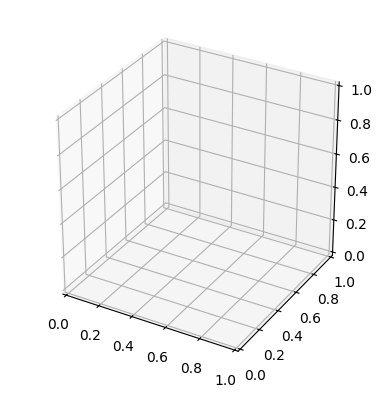

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

A =  [[1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]]
eigenvalues, eigenvectors = np.linalg.eigh(A)

def plot_quadric(eigenvalues, tol=1e-9, L=2.0):
    ev = np.asarray(eigenvalues, dtype=float)

    zero_idx = np.where(np.abs(ev) <= tol)[0]
    nz_idx   = np.where(np.abs(ev) >  tol)[0]

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    title = classify(ev)
    ax.set_box_aspect([1, 1, 1], zoom = 0.92)


    if len(zero_idx) == 0:
        a, b, c = np.sqrt(1 / np.abs(ev))

        u = np.linspace(0, 2*np.pi, 500)
        v = np.linspace(0, np.pi, 500)

        if np.all(ev > 0):  # Ellipsoid
            x = a * np.outer(np.cos(u), np.sin(v))
            y = b * np.outer(np.sin(u), np.sin(v))
            z = c * np.outer(np.ones_like(u), np.cos(v))
            fc = shade_parametric_surface(x, y, z,ambient=0.12,
                              diffuse=0.88,
                              specular=0.35,
                              shininess=80)
            ax.plot_surface(x, y, z,facecolors=fc, shade=False, alpha=0.9,
                linewidth=0, edgecolor=(0,0,0,0.04))
            ax.set_xlabel("x'"); ax.set_ylabel("y'"); ax.set_zlabel("z'")
            plt.savefig("plot.pdf")
        return



print(f"Eigenvalues: {eigenvalues}")
print(f"Surface Classification: Sphere")



plot_quadric([eigenvalues[0], eigenvalues[1], eigenvalues[2]])

